# 1. Load Library

In this section we import all the necessary libraries.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import os
import random

from scipy.sparse import csr_matrix, vstack
from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import SGDRegressor     # partial_fit for online learning
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder     # Support Sparse Matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

offline_seed = 42
print('Libraries loaded successfully')

Libraries loaded successfully


# 2. Load Dataset

Load the dataset (e.g., a CSV file) and preview it.

In [16]:
# Download from Kaggle or load preprocessed data
current_path = None
if not current_path:
    path = kagglehub.dataset_download("samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc")

    files = os.listdir(path)
    csv_path = os.path.join(path, 'GDSC_Cleaned.csv')
    df = pd.read_csv(csv_path)
    df.head()

print("Path to dataset files:", path)

Path to dataset files: C:\Users\LiuXirui\.cache\kagglehub\datasets\samiraalipour\genomics-of-drug-sensitivity-in-cancer-gdsc\versions\2


In [17]:
print(df.shape)
df.head()

(214880, 19)


,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,LN_IC50,AUC,Z_SCORE,GDSC Tissue descriptor 1,GDSC Tissue descriptor 2,Cancer Type (matching TCGA label),Microsatellite instability Status (MSI),Screen Medium,Growth Properties,CNA,Gene Expression,Methylation,TARGET,TARGET_PATHWAY
0,683667,PFSK-1,MB,1003,Camptothecin,-1.463887,0.930220,0.433123,nervous_system,medulloblastoma,MB,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
1,684057,ES5,UNCLASSIFIED,1003,Camptothecin,-3.360586,0.791072,-0.599569,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
2,684059,ES7,UNCLASSIFIED,1003,Camptothecin,-3.452815,0.592660,-1.516647,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
3,684062,EW-11,UNCLASSIFIED,1003,Camptothecin,-3.452815,0.734047,-0.807232,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
4,684072,SK-ES-1,UNCLASSIFIED,1003,Camptothecin,-3.452815,0.582439,-1.570016,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Semi-Adherent,Y,Y,Y,TOP1,DNA replication


In [18]:
# check drug id = 1003 drug name
drug_id = 1003
drug_name = df[df['DRUG_ID'] == drug_id]['DRUG_NAME'].values[0]
print(f"Drug ID: {drug_id}, Drug Name: {drug_name}")

Drug ID: 1003, Drug Name: Camptothecin


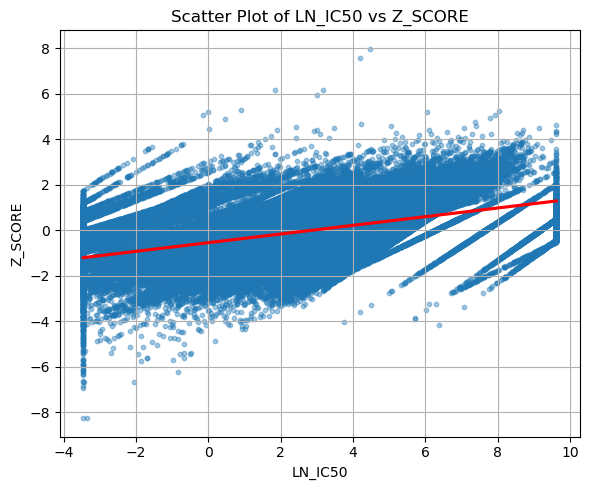

In [19]:
# 移除缺失值
subset = df[["LN_IC50", "Z_SCORE"]].dropna()

# 散点图 + 拟合线
plt.figure(figsize=(6, 5))
sns.regplot(data=subset, x="LN_IC50", y="Z_SCORE", scatter_kws={'s': 10, 'alpha': 0.4}, line_kws={'color': 'red'})
plt.title("Scatter Plot of LN_IC50 vs Z_SCORE")
plt.xlabel("LN_IC50")
plt.ylabel("Z_SCORE")
plt.grid(True)
plt.tight_layout()
plt.show()


## 3. Skewness

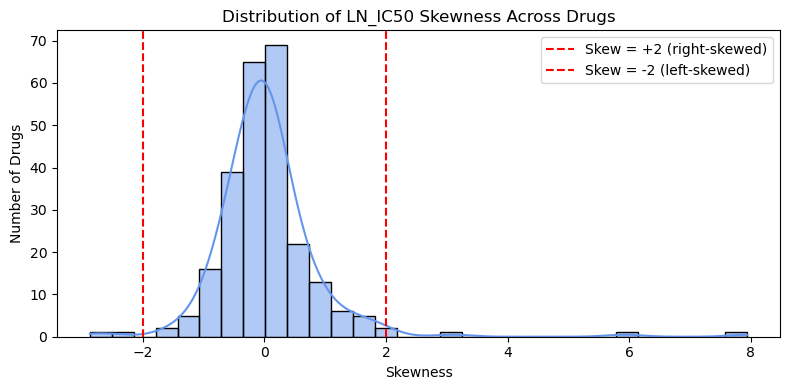

In [23]:
from scipy.stats import skew
import seaborn as sns

# 2. Compute skewness for each drug
drug_skews = []
for drug, group in df.groupby("DRUG_NAME"):
    values = group["LN_IC50"].dropna()
    if len(values) >= 10:  # Only consider drugs with enough samples
        s = skew(values)
        drug_skews.append((drug, s))

skew_df = pd.DataFrame(drug_skews, columns=["DRUG_NAME", "Skewness"])
skew_df = skew_df.sort_values("Skewness")

# 3. Plot histogram of skewness values
plt.figure(figsize=(8, 4))
sns.histplot(skew_df["Skewness"], bins=30, kde=True, color='cornflowerblue')
plt.axvline(2, color='red', linestyle='--', label='Skew = +2 (right-skewed)')
plt.axvline(-2, color='red', linestyle='--', label='Skew = -2 (left-skewed)')
plt.title("Distribution of LN_IC50 Skewness Across Drugs")
plt.xlabel("Skewness")
plt.ylabel("Number of Drugs")
plt.legend()
plt.tight_layout()
plt.show()

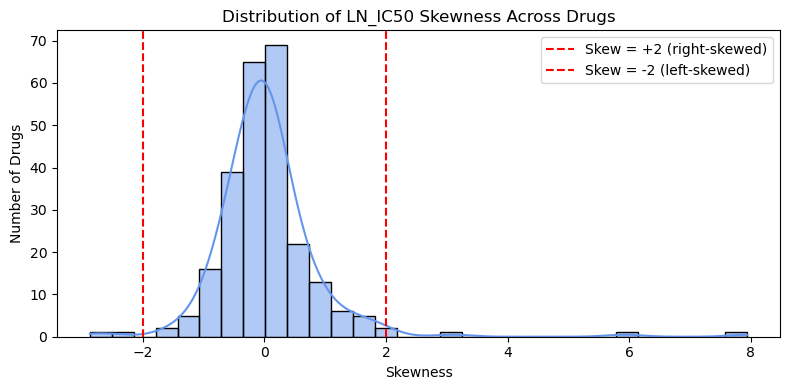

In [31]:
from scipy.stats import skew
import seaborn as sns

# 2. Compute skewness for each drug
drug_skews = []
for drug, group in df.groupby("DRUG_NAME"):
    values = group["LN_IC50"].dropna()
    if len(values) >= 10:  # Only consider drugs with enough samples
        s = skew(values)
        drug_skews.append((drug, s))

skew_df = pd.DataFrame(drug_skews, columns=["DRUG_NAME", "Skewness"])
skew_df = skew_df.sort_values("Skewness")

# 3. Plot histogram of skewness values
plt.figure(figsize=(8, 4))
sns.histplot(skew_df["Skewness"], bins=30, kde=True, color='cornflowerblue')
plt.axvline(2, color='red', linestyle='--', label='Skew = +2 (right-skewed)')
plt.axvline(-2, color='red', linestyle='--', label='Skew = -2 (left-skewed)')
plt.title("Distribution of LN_IC50 Skewness Across Drugs")
plt.xlabel("Skewness")
plt.ylabel("Number of Drugs")
plt.legend()
plt.tight_layout()
plt.show()

Drug closest to skew=-3: N-acetyl cysteine


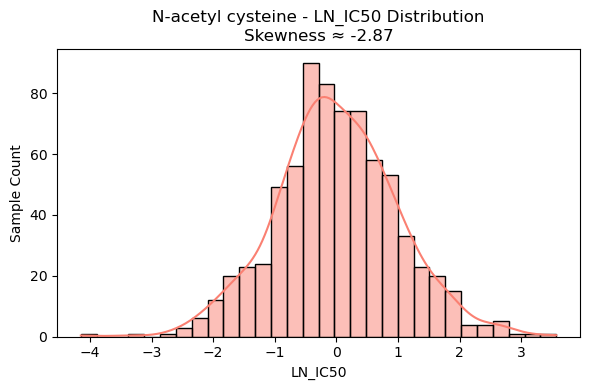

In [33]:
# 1. 查找偏度最接近 2 的药物
target_skew = -3
closest_drug = skew_df.iloc[(skew_df["Skewness"] - target_skew).abs().argsort()[:1]]
drug_name = closest_drug["DRUG_NAME"].values[0]
print(f"Drug closest to skew={target_skew}: {drug_name}")

# 2. 提取该药物的 LN_IC50 分布
drug_ic50 = df[df["DRUG_NAME"] == drug_name]["LN_IC50"].dropna()

# 3. 可视化
plt.figure(figsize=(6, 4))
sns.histplot(drug_ic50, bins=30, kde=True, color='salmon', edgecolor='black')
plt.title(f"{drug_name} - LN_IC50 Distribution\nSkewness ≈ {closest_drug['Skewness'].values[0]:.2f}")
plt.xlabel("LN_IC50")
plt.ylabel("Sample Count")
plt.tight_layout()
plt.show()

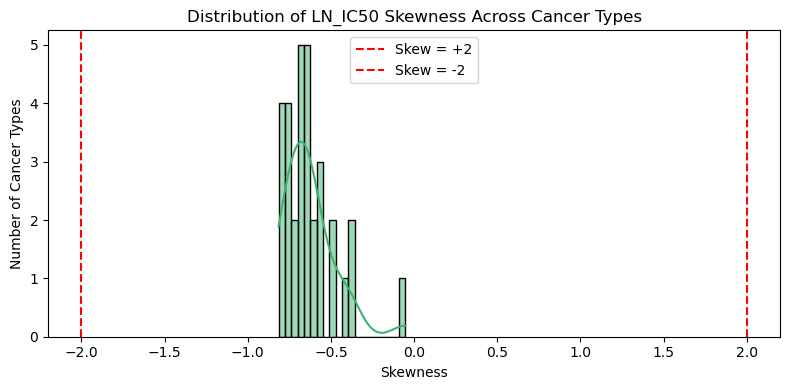

In [25]:
# 2. 按癌症类型分组计算 LN_IC50 的偏度
cancer_skews = []
for cancer, group in df.groupby("Cancer Type (matching TCGA label)"):
    values = group["LN_IC50"].dropna()
    if len(values) >= 10:
        s = skew(values)
        cancer_skews.append((cancer, s))

skew_df = pd.DataFrame(cancer_skews, columns=["CANCER_TYPE", "Skewness"])
skew_df = skew_df.sort_values("Skewness")

# 3. 绘制偏度分布图（癌种维度）
plt.figure(figsize=(8, 4))
sns.histplot(skew_df["Skewness"], bins=20, kde=True, color='mediumseagreen')
plt.axvline(2, color='red', linestyle='--', label='Skew = +2')
plt.axvline(-2, color='red', linestyle='--', label='Skew = -2')
plt.title("Distribution of LN_IC50 Skewness Across Cancer Types")
plt.xlabel("Skewness")
plt.ylabel("Number of Cancer Types")
plt.legend()
plt.tight_layout()
plt.show()

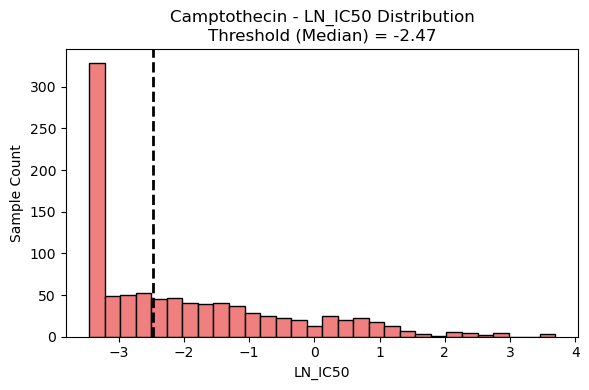

In [ ]:
# 2. Calculate the median LN_IC50 for each drug (used as threshold)
thresholds = (
    df
    .groupby("DRUG_NAME")["LN_IC50"]
    .median()
    .sort_values()
)

# 4. Optional: Plot LN_IC50 distribution for a specific drug
def plot_ic50_distribution(drug_name, df, thresholds):
    """
    Plot the distribution of LN_IC50 for a specific drug,
    with the threshold (median) shown as a vertical line.
    """
    subset = df[df["DRUG_NAME"] == drug_name]
    if subset.empty:
        print(f"Drug {drug_name} not found in the dataset.")
        return

    threshold = thresholds.loc[drug_name]
    plt.figure(figsize=(6, 4))
    plt.hist(subset["LN_IC50"], bins=30, edgecolor='black', color='lightcoral')
    plt.axvline(threshold, color='black', linestyle='--', linewidth=2)
    plt.xlabel("LN_IC50")
    plt.ylabel("Sample Count")
    plt.title(f"{drug_name} - LN_IC50 Distribution\nThreshold (Median) = {threshold:.2f}")
    plt.tight_layout()
    plt.show()

plot_ic50_distribution("Camptothecin", df, thresholds)

# Example: Plot distributions for the 3 most potent drugs (lowest thresholds)
#for drug in thresholds.index[:3]:
#    plot_ic50_distribution(drug, df, thresholds)